# 1. Preprocessing wind turbine data from Marktstammdatenregister (MaStR)

#### In this notebook:
- I began the first steps in preprocessing the onshore wind turbine dataset from MaStR,
- replaced codes with their corresponding string values using MaStR catalogue XML,
- dropped data I didn't want to keep
- applied various transformations to clean the data
- validated the dataset and used KNN imputer to fill missing values (never used in model training)

#### Notes to self:
- Windkraft an Land: 32700
- Windkraft auf See: 1784
- I'm looking only at onshore turbines in column `Lage`
- Lat and lon is NOT a required field for registering turbine one MaStR! However, postcode is required :)
- Bruttoleistung and Nettonennleistung are required fields
    - Bruttoleistung: Entspricht Nettonennleistung
    - Nettonennleistung: 0 < X <= 20.000 und X <= Bruttoleistung

In [606]:
import sys
from pathlib import Path
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [3]:
print(sys.executable)
print(sys.version)

/opt/miniconda3/envs/course_project/bin/python
3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:39:40) [Clang 15.0.7 ]


#### Paths 

In [583]:
# Create absolute path object to data directory
# Note: cwd
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Helper functions

In [537]:
def swept_area_by_blades(d):
    """
    d is the diameter in meters
    returns the so-called capture area in m^2
    """
    area = 0.25 * math.pi * pow(d, 2)
    return int(area)

----

### Creating a mapping of categories, ids, and values

In [253]:
# Load in catalogue ids from XML file
df_xml_catalogue = pd.read_xml(data_path / 'Katalogkategorien.xml', encoding='utf-16')
df_xml_catalogue.rename(columns={'Id': 'category_id', 'Name': 'category_name',}, inplace=True)
df_xml_catalogue.set_index('category_id', inplace=True)

catalogue_categories_to_keep = [
    'Betriebsstatus',  # EinheitBetriebsstatus
    # 'Land',
    'BundeslaenderEinheiten',  # don't use 'Bundesland'
    'Einspeisungsart',
    'WindLage',
    'WindHersteller',
    'Windanlagentechnologie', 
]

df_xml_catalogue = df_xml_catalogue[df_xml_catalogue['category_name'].isin(catalogue_categories_to_keep)]


# Load in catalogue values from XML file
df_xml_cat_values = pd.read_xml(data_path / 'Katalogwerte.xml', encoding='utf-16')
df_xml_cat_values.rename(columns={'Id': 'value_id', 'Wert': 'value', 'KatalogKategorieId': 'category_id'}, inplace=True)
df_xml_cat_values.set_index('category_id', inplace=True)


# Merging the two dataframes
df_cat_lookup_reference = df_xml_catalogue.merge(df_xml_cat_values, how='left', left_index=True, right_index=True)
df_cat_lookup_reference

,category_name,value_id,value
category_id,,,
4,Betriebsstatus,31,In Planung
4,Betriebsstatus,35,In Betrieb
4,Betriebsstatus,37,Vorübergehend stillgelegt
4,Betriebsstatus,38,Endgültig stillgelegt
52,Einspeisungsart,688,Volleinspeisung
...,...,...,...
101,BundeslaenderEinheiten,1412,Saarland
101,BundeslaenderEinheiten,1413,Sachsen
101,BundeslaenderEinheiten,1414,Sachsen-Anhalt


In [254]:
# quickly search for cat names
# df_xml_catalogue[df_xml_catalogue['category_name'].str.contains('undes')]

In [255]:
# 5 cat ids in catalogue index not in cat_values index
# idx_difference = df_xml_catalogue.index.difference(df_xml_cat_values.index)
# df_xml_catalogue.loc[idx_difference]

In [256]:
# df_cat_lookup_reference[df_cat_lookup_reference['category_name'] == 'BundeslaenderEinheiten']

-----

## Read in original XML dataset

In [400]:
# Read in data
df_xml_original = pd.read_xml(data_path / 'EinheitenWind.xml', encoding='utf-16')
df_xml = df_xml_original.copy()

# define columns to keep
columns_to_keep = [
    'EinheitMastrNummer',
    'DatumLetzteAktualisierung',
    # 'NetzbetreiberpruefungStatus',  # Der Status der letzten Netzbetreiberprüfung, insofern eine durchgeführt wurde
    # 'Land',  # all code 84: Deutschland
    'Bundesland',
    'Postleitzahl',
    'Ort',
    'Laengengrad',
    'Breitengrad',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    # 'EinheitSystemstatus',  # all code 472: active
    'EinheitBetriebsstatus',
    'NameStromerzeugungseinheit',
    # 'Energietraeger',  # all code 2497: Wind
    # 'Bruttoleistung',  # float, WARNING: this is the Nettonennleistung so remove
    'Nettonennleistung',  # float
    'AnschlussAnHoechstOderHochSpannung',  # bool
    'Einspeisungsart',
    'NameWindpark',
    'Lage',  # int
    'Hersteller',  # int
    'Technologie',  # int
    'Typenbezeichnung',
    'Nabenhoehe',
    'Rotordurchmesser',
    'Rotorblattenteisungssystem',  # bool
    
    # --- other date columns ---- 
    # 'GeplantesInbetriebnahmedatum',  # these are future dates
    # 'DatumDesBetreiberwechsels', 
    # 'DatumRegistrierungDesBetreiberwechsels',
    'DatumEndgueltigeStilllegung',  # need this one
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb',
]

# filter columns
df_xml = df_xml[columns_to_keep]
df_xml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34822 entries, 0 to 34821
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   EinheitMastrNummer                     34822 non-null  object 
 1   DatumLetzteAktualisierung              34822 non-null  object 
 2   Bundesland                             34822 non-null  int64  
 3   Postleitzahl                           33037 non-null  float64
 4   Ort                                    33037 non-null  object 
 5   Laengengrad                            33907 non-null  float64
 6   Breitengrad                            33907 non-null  float64
 7   Registrierungsdatum                    34822 non-null  object 
 8   Inbetriebnahmedatum                    32208 non-null  object 
 9   EinheitBetriebsstatus                  34822 non-null  int64  
 10  NameStromerzeugungseinheit             34822 non-null  object 
 11  Ne

In [401]:
# df_xml_original.info()

In [402]:
# df_xml_original[df_xml_original['DatumWiederaufnahmeBetrieb'].notna()]

In [356]:
# df_xml_original[~(df_xml_original['DatumEndgueltigeStilllegung'].isna())]

In [403]:
df_xml.sample(3)

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,NameStromerzeugungseinheit,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb
4615,SEE955279524682,2019-05-28T08:26:38.0316692,1410,54595.0,Weinsheim,6.483001,50.216280,2019-05-02,2001-11-23,35,58056,1000.0,0.0,688.0,WPI Kramberg,888.0,1586.0,691,E-58/10.58,73.0,58.0,NaN,None,None,None
9829,SEE945834955143,2023-03-22T09:12:05.7632421,1400,17291.0,Uckerfelde,13.959032,53.269090,2021-06-29,2021-06-28,35,WKA MM4,4200.0,NaN,688.0,Windpark Bietikow,888.0,1586.0,691,Enercon E138 EP3 E2,160.0,138.0,0.0,None,None,None
11163,SEE939390123399,2023-05-26T11:44:38.7070806,1414,6682.0,Teuchern,11.958813,51.145445,2020-11-03,2020-10-28,35,WP Vier Berge- WEA 59N,3500.0,1.0,688.0,WP Vier Berge,888.0,1586.0,691,E-138,160.0,138.0,0.0,None,None,None


----

### Function to replace value IDs with values in columns using lookup df

In [404]:
df_cat_lookup_reference['category_name'].unique()

array(['Betriebsstatus', 'Einspeisungsart', 'Windanlagentechnologie',
       'WindHersteller', 'WindLage', 'BundeslaenderEinheiten'],
      dtype=object)

In [405]:
df_cat_lookup_reference[df_cat_lookup_reference['category_name'] == 'Betriebsstatus']

,category_name,value_id,value
category_id,,,
4,Betriebsstatus,31,In Planung
4,Betriebsstatus,35,In Betrieb
4,Betriebsstatus,37,Vorübergehend stillgelegt
4,Betriebsstatus,38,Endgültig stillgelegt


In [406]:
def replace_ids_with_values(columns, df_cat_lookup_reference):
    # col 1: Bundesland
    if columns.index[0] == 'Bundesland':
        try:
            bundesland_id = columns[0]
            bundesland_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'BundeslaenderEinheiten') & (df_cat_lookup_reference['value_id'] == bundesland_id)]['value']
            columns[0] = bundesland_value.values.item()
        except:
            columns[0] = np.nan
    else:
        pass
        
    # col 2: Betriebsstatus/EinheitBetriebsstatus
    if columns.index[1] == 'EinheitBetriebsstatus':
        try:
            betriebsstatus_id = columns[1]
            betriebsstatus_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Betriebsstatus') & (df_cat_lookup_reference['value_id'] == betriebsstatus_id)]['value']
            columns[1] = betriebsstatus_value.values.item()
        except:
            columns[1] = np.nan
    else:
        pass
    
    # col 3: Einspeisungsart
    if columns.index[2] == 'Einspeisungsart':
        try:
            einspeisungsart_id = columns[2]
            einspeisungsart_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Einspeisungsart') & (df_cat_lookup_reference['value_id'] == einspeisungsart_id)]['value']
            columns[2] = einspeisungsart_value.values.item()
        except:
            columns[2] = np.nan
    else:
        pass
    
    # col 4: WindLage/Lage
    if columns.index[3] == 'Lage':
        try:
            lage_id = columns[3]
            lage_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'WindLage') & (df_cat_lookup_reference['value_id'] == lage_id)]['value']
            columns[3] = lage_value.values.item()
        except:
            columns[3] = np.nan
    else:
        pass
    
    # col 5: WindHersteller/Hersteller
    if columns.index[4] == 'Hersteller':
        try:
            hersteller_id = columns[4]
            hersteller_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'WindHersteller') & (df_cat_lookup_reference['value_id'] == hersteller_id)]['value']
            columns[4] = hersteller_value.values.item()
        except:
            columns[4] = np.nan
    else:
        pass
    
    # col 6: Windanlagentechnologie/Technologie
    if columns.index[5] == 'Technologie':
        try:
            technologie_id = columns[5]
            technologie_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Windanlagentechnologie') & (df_cat_lookup_reference['value_id'] == technologie_id)]['value']
            columns[5] = technologie_value.values.item()
        except:
            columns[5] = np.nan
    else:
        pass
    
    return columns

In [407]:
# Run the replace function
# Takes 1 min 40s to run on 2019 16" MBP (clearly not performant code!)
df_xml_replaced_ids = df_xml[['Bundesland', 'EinheitBetriebsstatus', 'Einspeisungsart', 'Lage', 'Hersteller', 'Technologie']].apply(
    replace_ids_with_values, axis=1, df_cat_lookup_reference=df_cat_lookup_reference
)

# Update main df in place using new values of subset df (essentially a left-join merge)
df_xml.update(df_xml_replaced_ids)

### Use available postcodes to insert missing lat & lon data using postcodes CSV
- Source: https://github.com/WZBSocialScienceCenter/plz_geocoord

In [408]:
df_postcodes_coords = pd.read_csv(data_path / 'plz_geocoord.csv', sep=',')
df_postcodes_coords.rename(columns={'Unnamed: 0': 'postcode', 'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
df_postcodes_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8298 entries, 0 to 8297
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   postcode   8298 non-null   int64  
 1   latitude   8298 non-null   float64
 2   longitude  8298 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 194.6 KB


In [409]:
df_postcodes_coords.head(2)

,postcode,latitude,longitude
0,1067,51.057550,13.717065
1,1069,51.039135,13.737675


In [410]:
# Function that inserts lats and lons using postcode csv
def add_coords_using_postcode(cols, df_postcodes_coords):
    # Get turbine postcode
    postcode_to_look_up = int(cols[0])
    # Get row in postcode csv using postcode as key
    lookup_row = df_postcodes_coords.loc[df_postcodes_coords['postcode'] == postcode_to_look_up]
    # Try assigning lon and lat
    try:
        cols[1] = lookup_row['longitude']
        cols[2] = lookup_row['latitude']
    except: 
        return cols
    return cols

In [411]:
# Turbines missing coords and their postcodes
# One turbine postcode is not present in the postcode csv
# That turbine has postcode 99095 (Erfurt, Thuringia according to Google)
# It's a small turbine (Tesup Atlas2.0) and can be dropped
df_xml[df_xml['Laengengrad'].isna()]['Postleitzahl'].isin(df_postcodes_coords['postcode']).value_counts()

# Postal code 99095 is Erfurt, Thuringia according to Google
# df_coords_missing[~df_coords_missing['Postleitzahl'].isin(df_postcodes_coords['postcode'])]

Postleitzahl
True     912
False      3
Name: count, dtype: int64

In [412]:
df_xml.isna().sum()

EinheitMastrNummer                           0
DatumLetzteAktualisierung                    0
Bundesland                                   0
Postleitzahl                              1785
Ort                                       1785
Laengengrad                                915
Breitengrad                                915
Registrierungsdatum                          0
Inbetriebnahmedatum                       2614
EinheitBetriebsstatus                        0
NameStromerzeugungseinheit                   0
Nettonennleistung                            0
AnschlussAnHoechstOderHochSpannung       10511
Einspeisungsart                            655
NameWindpark                               817
Lage                                         1
Hersteller                                 455
Technologie                                  0
Typenbezeichnung                           472
Nabenhoehe                                 866
Rotordurchmesser                           458
Rotorblattent

In [413]:
# Dataframe of turbines missing coords
df_coords_missing = df_xml[(df_xml['Laengengrad'].isna()) & (df_xml['Breitengrad'].isna())]

# Apply function and assign values back to relevant columns
df_coords_missing.loc[:, ['Postleitzahl', 'Laengengrad', 'Breitengrad']] = df_coords_missing[['Postleitzahl', 'Laengengrad', 'Breitengrad']].apply(
    add_coords_using_postcode, axis=1, df_postcodes_coords=df_postcodes_coords
)

# Update original df in place using new values of subset df (essentially a left-join merge)
df_xml.update(df_coords_missing)

In [414]:
df_xml.isna().sum()

EinheitMastrNummer                           0
DatumLetzteAktualisierung                    0
Bundesland                                   0
Postleitzahl                              1785
Ort                                       1785
Laengengrad                                  3
Breitengrad                                  3
Registrierungsdatum                          0
Inbetriebnahmedatum                       2614
EinheitBetriebsstatus                        0
NameStromerzeugungseinheit                   0
Nettonennleistung                            0
AnschlussAnHoechstOderHochSpannung       10511
Einspeisungsart                            655
NameWindpark                               817
Lage                                         1
Hersteller                                 455
Technologie                                  0
Typenbezeichnung                           472
Nabenhoehe                                 866
Rotordurchmesser                           458
Rotorblattent

- Investigate these 1785 missing postcodes! 
    - 1688 of them are Bundesland: Ausschließliche Wirtschaftszone
    - And all 1784 of them are offshore turbines! (Windkraft auf See)
- Drop the 3 turbines missing coordinates.. but first look at them. Are they big turbines?
- Then start re-using the wrangling code I wrote for the Kaggle dataset (filter for onshore turbines only, etc)

In [415]:
df_xml[df_xml['Postleitzahl'].isna()]['Bundesland'].value_counts()

Bundesland
Ausschließliche Wirtschaftszone    1688
Niedersachsen                        48
Mecklenburg-Vorpommern               48
Thüringen                             1
Name: count, dtype: int64

----

### Filters on `df_xml` and handling dtypes
- Keeping just onshore wind turbines, etc and other transformations

In [416]:
# Keep only onshore turbines and then drop Lage column
df_xml = df_xml.loc[df_xml['Lage'] == 'Windkraft an Land']
df_xml.drop(columns=['Lage'], inplace=True)
# Drop turbines in planning (there are 2614 of them)
df_xml = df_xml.loc[~(df_xml['EinheitBetriebsstatus'] == 'In Planung')]
# Convert postcodes from float to int
df_xml['Postleitzahl'] = df_xml['Postleitzahl'].astype('int')
# Drop the single small turbine that has nan in longitude or latitude columns (SEE900014803461)
df_xml.dropna(subset=['Laengengrad', 'Breitengrad'], inplace=True)

# Convert date features to datetime objects
df_xml['DatumLetzteAktualisierung'] = pd.to_datetime(df_xml['DatumLetzteAktualisierung'], yearfirst=True)
df_xml['Registrierungsdatum'] = pd.to_datetime(df_xml['Registrierungsdatum'], yearfirst=True)
df_xml['Inbetriebnahmedatum'] = pd.to_datetime(df_xml['Inbetriebnahmedatum'], yearfirst=True)
df_xml['DatumEndgueltigeStilllegung'] = pd.to_datetime(df_xml['DatumEndgueltigeStilllegung'], yearfirst=True)
df_xml['DatumBeginnVoruebergehendeStilllegung'] = pd.to_datetime(df_xml['DatumBeginnVoruebergehendeStilllegung'], yearfirst=True)
df_xml['DatumWiederaufnahmeBetrieb'] = pd.to_datetime(df_xml['DatumWiederaufnahmeBetrieb'], yearfirst=True)

df_xml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30645 entries, 0 to 34818
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   EinheitMastrNummer                     30645 non-null  object        
 1   DatumLetzteAktualisierung              30645 non-null  datetime64[ns]
 2   Bundesland                             30645 non-null  object        
 3   Postleitzahl                           30645 non-null  int64         
 4   Ort                                    30645 non-null  object        
 5   Laengengrad                            30645 non-null  float64       
 6   Breitengrad                            30645 non-null  float64       
 7   Registrierungsdatum                    30645 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                    30645 non-null  datetime64[ns]
 9   EinheitBetriebsstatus                  30645 non-null  object     

In [417]:
df_xml.isna().sum()

EinheitMastrNummer                           0
DatumLetzteAktualisierung                    0
Bundesland                                   0
Postleitzahl                                 0
Ort                                          0
Laengengrad                                  0
Breitengrad                                  0
Registrierungsdatum                          0
Inbetriebnahmedatum                          0
EinheitBetriebsstatus                        0
NameStromerzeugungseinheit                   0
Nettonennleistung                            0
AnschlussAnHoechstOderHochSpannung        8574
Einspeisungsart                            438
NameWindpark                               786
Hersteller                                 257
Technologie                                  0
Typenbezeichnung                           262
Nabenhoehe                                 746
Rotordurchmesser                           378
Rotorblattenteisungssystem                7379
DatumEndguelt

#### Re-order columns for better print inspection 

In [418]:
# df_xml.columns.to_list()

In [419]:
new_column_order = [
    'EinheitMastrNummer',
    'DatumLetzteAktualisierung',
    'Bundesland',
    'Postleitzahl',
    'Ort',
    'Laengengrad',
    'Breitengrad',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    'EinheitBetriebsstatus',
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb',
    'NameStromerzeugungseinheit',
    'Nettonennleistung',
    'AnschlussAnHoechstOderHochSpannung',
    'Einspeisungsart',
    'NameWindpark',
    'Hersteller',
    'Technologie',
    'Typenbezeichnung',
    'Nabenhoehe',
    'Rotordurchmesser',
    'Rotorblattenteisungssystem',
]

df_xml = df_xml[new_column_order]

### Save wrangled dataframe as pickle for fast loading

In [420]:
# # reset index before saving
# df_xml.reset_index(drop=True, inplace=True)

# # serialise/pickle dataframe to pickle file 
# df_xml.to_pickle(data_path / 'df_turbines_xml_wrangled.pkl')

-----

## Load pickle file of wrangled data back into dataframe

In [590]:
# test load pickle file back into df
# keeps correct dtypes including datetime objects! Noice! 
df = pd.read_pickle(data_path / 'df_turbines_xml_wrangled.pkl')

In [592]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30645 entries, 0 to 30644
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   EinheitMastrNummer                     30645 non-null  object        
 1   DatumLetzteAktualisierung              30645 non-null  datetime64[ns]
 2   Bundesland                             30645 non-null  object        
 3   Postleitzahl                           30645 non-null  int64         
 4   Ort                                    30645 non-null  object        
 5   Laengengrad                            30645 non-null  float64       
 6   Breitengrad                            30645 non-null  float64       
 7   Registrierungsdatum                    30645 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                    30645 non-null  datetime64[ns]
 9   EinheitBetriebsstatus                  30645 non-null  object

In [593]:
# Check that each turbine is unique using its MastrNummer
df.iloc[:,0].nunique() == len(df)

True

------

## More info about the most important features of this wind turbine dataset

#### Die Nettonennleistung (required field)
- Die höchste elektrische Dauerleistung unter Nennbedingungen, die eine Energieumwandlungsanlage erreicht. ln der Nettonennleistung ist die Eigenverbrauchsleistung während des Betriebs der Anlage nicht enthalten.
- The net nominal power does NOT include the self-consumption power during the operation of the plant.
- Die Nettonennleistung(Produktion) ist die höchste Dauerleistung unter Nennbedingungen, die eine Erzeugungseinheit zum Übergabezeitpunkt erreicht
- The net nominal power (production) is the highest continuous power under nominal conditions achieved by a generating unit at the time of delivery
- https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Energie/Glossar/nettonennleistung.html
- Remember: units are in kW! 2,000 kW = 2 MW

#### Bruttoleistung - WARNING: this is just the Nettonennleistung (net nominal power) copied into the Bruttoleistung by the system - REMOVE
- Die an den Klemmen des Generators abgegebene Leistung.
- Bei Windenergie ist die Bruttoleistung im MaStR stets gleich der Nettonennleistung. Die Bruttoleistung kann bei Windenergie nicht eigenständig eingetragen werden. Vom System wird der Wert der Nettonennleistung übernommen. Die Nettonennleistung kann bei Solaranlagen nicht vom Benutzer eingetragen werden.

#### Inbetriebnahmedatum (not a required field)
- Erstmalige Inbetriebsetzung der Stromerzeugungseinheit nach Herstellung der technischen Betriebsbereitschaft. Die technische Betriebsbereitschaft setzt voraus, dass die Stromerzeugungseinheit fest an dem für den dauerhaften Betrieb vorgesehenen Ort und dauerhaft mit dem für die Erzeugung von Wechselstrom erforderlichen Zubehör installiert wurde.
    - Initial commissioning of the power generation unit after technical readiness for operation has been established. Technical readiness for operation presupposes that the power generation unit has been permanently installed in the place intended for permanent operation and permanently with the accessories required for the generation of alternating current.

#### EinheitBetriebsstatus (required field)
- In Betrieb (in operation): 29445
- Endgültig stillgelegt (Decommissioned for good): 1158
    - Good news: all 1158 decommissioned turbines have dates when they stopped operating in the field `DatumEndgueltigeStilllegung`
- Vorübergehend stillgelegt (Temporarily shut down): 42
    - ~Remove these since I don't know how long they've been temporarily shut down and it's only 42 turbines with a Nettonennleistung sum of 44,134 kW~
    - Update: no keep them since I DO have the date for all 42 in the field `DatumBeginnVoruebergehendeStilllegung`
    - But I also have 68 dates in this field.. why is that? 21 have a date in this field AND are decommissioned. That gets us to 63. The other 5?
        - All solved and accounted for. The other 5 are in operation but were temporarily shut down but also have dates they went back into operation in the field `DatumWiederaufnahmeBetrieb`
        - But 6 have date in `DatumWiederaufnahmeBetrieb`, one turbine was decommissioned permanently and this date is same as in `DatumWiederaufnahmeBetrieb`

#### Einspeisungsart (not a required field)
- Volleinspeisung: 28,348 (94%)
    - All electricity generated from the turbine is fed into the public grid
- Teileinspeisung (einschließlich Eigenverbrauch): 1,859 (6%)
    - Since the amount going into the grid is likely variable, just assume 50% when calculating generation per hour/day
- 438 are missing this info


#### Technical fields
- Typenbezeichnung (required field)
    - Missing: 262
- Nabenhoehe (required field)
    - Missing: 746
    - For 479 of these I have the blade diameter (can estimate from that)
- Rotordurchmesser (required field)
    - Missing: 378
    - For 111 of these I have hub height data!
- For 267 turbines I'm missing both hub height AND blade dia
    - What to do with these?
    - I could find a relationship between these three and then fit to the curve?

-----

### Further wrangling ideas and to do:
- ~Convert kW to MW in Nettonennleistung?~
    - no point; handle at point of calculation or not at all
- ~Remove all turbines not currently in operation? I don’t have date when it went out of operation so I?~
    - I do have these dates!
- ~Should I fill nans in rotor dia using mean or whatever? I shouldn’t have any nans here!~
    - I used KNN imputation
- ~Create derived column for area swept by blades~
- I also need a container for each row holding tuples of coords, leistung, rotor diameter
- Reshape data to be a period time series, aggregating continuous features like Nettonennleistung at a daily/hourly resolution
- For each day in period index (e.g. daily), do conditional filter on in operation date ON or AFTER period Index day. Then aggregate sum or count on those turbines and put those into derived columns. 

### Use KNN imputation using hub height, rotor blade, and net power to fill missing values!
- Remember this is an imputer and there are no labeled data (no supervision)

In [594]:
# assign the three features to X
df_X = df[['Nettonennleistung', 'Nabenhoehe', 'Rotordurchmesser']]

# knn imputation of the three features
knn_imputer = KNNImputer(n_neighbors=5).set_output(transform="pandas")
df_X = knn_imputer.fit_transform(df_X)

# update main df with imputed data
df.update(df_X)

In [595]:
df_X.isna().sum()

Nettonennleistung    0
Nabenhoehe           0
Rotordurchmesser     0
dtype: int64

#### Derive new column for swept area of blade

In [596]:
df['area_blades'] = df['Rotordurchmesser'].apply(swept_area_by_blades)

In [584]:
# save df to data to push dir so it lands in GitHub repo
# df.to_pickle(data_push_path / 'df_turbines_knn_wrangled.pkl')

### Read in data 

#### More info about the features
- Bruttoleistung and Nettonennleistung in units kW
- Nabenhoehe, Rotordurchmesser, Typenbezeichnung are required fields 

In [97]:
# Wind turbine dataset
df = pd.read_csv(cwd_path.parent / 'data/WindTurbinesGermany.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34484 entries, 0 to 34483
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Land                                34484 non-null  object 
 1   Bundesland                          34484 non-null  object 
 2   Landkreis                           32700 non-null  object 
 3   Postleitzahl                        32700 non-null  float64
 4   Ort                                 32700 non-null  object 
 5   Laengengrad                         33589 non-null  float64
 6   Breitengrad                         33589 non-null  float64
 7   Registrierungsdatum                 34484 non-null  object 
 8   Inbetriebnahmedatum                 32020 non-null  object 
 9   EinheitBetriebsstatus               34484 non-null  object 
 10  Energietraeger                      34484 non-null  object 
 11  Bruttoleistung                      34484

In [98]:
df.isna().sum()

Land                                      0
Bundesland                                0
Landkreis                              1784
Postleitzahl                           1784
Ort                                    1784
Laengengrad                             895
Breitengrad                             895
Registrierungsdatum                       0
Inbetriebnahmedatum                    2464
EinheitBetriebsstatus                     0
Energietraeger                            0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung     9853
Einspeisungsart                         714
NameWindpark                            810
Lage                                      0
Hersteller                              449
Technologie                               0
Typenbezeichnung                        464
Nabenhoehe                              853
Rotordurchmesser                        453
Rotorblattenteisungssystem      

### Filtering ideas
- Keep only land-based turbines
- Keep only turbines with status EinheitBetriebsstatus = In Betrieb
    - Removes turbines that are no longer in operation (shame we don't know the date it fell out of service)
    - Removes turbines that are still in planning

In [356]:
# Keep only onshore turbines
df = df[df['Lage'] == 'Windkraft an Land']
# Drop turbines in planning (there are 2241 of them)
df = df[~(df['EinheitBetriebsstatus'] == 'In Planung')]
# Drop columns with all missing values (they were specific to offshore or planned turbines)
df.dropna(axis='columns', how='all', inplace=True)
# Convert postcodes from float to int
df['Postleitzahl'] = df['Postleitzahl'].astype('int')

# Convert date features to datetime objects
df['Registrierungsdatum'] = pd.to_datetime(df['Registrierungsdatum'])
df['Inbetriebnahmedatum'] = pd.to_datetime(df['Inbetriebnahmedatum'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30459 entries, 0 to 34483
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Land                                30459 non-null  object        
 1   Bundesland                          30459 non-null  object        
 2   Landkreis                           30459 non-null  object        
 3   Postleitzahl                        30459 non-null  int64         
 4   Ort                                 30459 non-null  object        
 5   Laengengrad                         29620 non-null  float64       
 6   Breitengrad                         29620 non-null  float64       
 7   Registrierungsdatum                 30459 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                 30459 non-null  datetime64[ns]
 9   EinheitBetriebsstatus               30459 non-null  object        
 10  Energietraeger             

In [357]:
df['Registrierungsdatum'].max()

Timestamp('2023-05-26 00:00:00')

In [358]:
df['Inbetriebnahmedatum'].max()

Timestamp('2023-05-26 00:00:00')

In [359]:
# other_columns_to_drop = ['Land', 'Bundesland', 'Landkreis', 'Postleitzahl', 'Ort', 'Lage', 'Energietraeger']

In [360]:
df.isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                            839
Breitengrad                            839
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8264
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             738
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [364]:
df.loc[34335]

Land                                                                      Deutschland
Bundesland                                                                  Thüringen
Landkreis                                                               Weimarer Land
Postleitzahl                                                                    99438
Ort                                                                          Buchfart
Laengengrad                                                                 11.267888
Breitengrad                                                                 50.896747
Registrierungsdatum                                               2023-05-04 00:00:00
Inbetriebnahmedatum                                               2023-05-01 00:00:00
EinheitBetriebsstatus                                                      In Betrieb
Energietraeger                                                                   Wind
Bruttoleistung                                        

In [365]:
df.isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                              1
Breitengrad                              1
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8264
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             738
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [526]:
# Drop the single row that has nan in longitude or latitude columns
df.dropna(subset=['Laengengrad', 'Breitengrad']).isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                              0
Breitengrad                              0
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8263
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             737
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [510]:
df['EinheitBetriebsstatus'].value_counts()

EinheitBetriebsstatus
In Betrieb                   29422
Endgültig stillgelegt          999
Vorübergehend stillgelegt       38
Name: count, dtype: int64

In [492]:
df[['Bruttoleistung', 'Nettonennleistung', 'Nabenhoehe', 'Rotordurchmesser']].describe()

,Bruttoleistung,Nettonennleistung,Nabenhoehe,Rotordurchmesser
count,30459.000000,30459.000000,29721.00000,30082.000000
mean,1971.220019,1971.220019,95.62819,80.146323
std,1098.310972,1098.310972,33.85736,30.672645
min,0.120000,0.120000,0.36000,0.300000
25%,1300.000000,1300.000000,67.00000,62.000000
50%,2000.000000,2000.000000,98.00000,80.000000
75%,2500.000000,2500.000000,125.00000,101.000000
max,8000.000000,8000.000000,173.48000,180.000000


<Axes: >

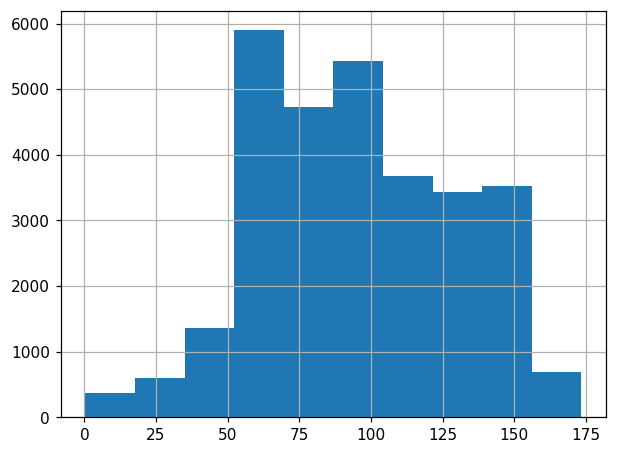

In [514]:
df['Nabenhoehe'].hist()

In [491]:
df[df['Nabenhoehe'].isna()]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
108,Deutschland,Niedersachsen,Nienburg (Weser),31592,Stolzenau,8.987413,52.485784,2019-02-04,2002-02-28,In Betrieb,Wind,600.0,600.0,NaN,Volleinspeisung,Auf dem Acker,Windkraft an Land,NaN,Horizontalläufer,Enercon-40/6.44,NaN,NaN,NaN
125,Deutschland,Bayern,Oberallgäu,87488,Betzigau,NaN,NaN,2019-04-09,2019-01-23,In Betrieb,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,FuSystems SkyWind GmbH,Vertikalläufer,NG,NaN,1.5,NaN
177,Deutschland,Niedersachsen,Aurich,26529,Upgant-Schott,7.200870,53.509760,2019-02-05,2012-01-16,In Betrieb,Wind,800.0,800.0,NaN,Volleinspeisung,E-53,Windkraft an Land,ENERCON GmbH,Horizontalläufer,Enercon E-53,NaN,53.0,NaN
219,Deutschland,Niedersachsen,Aurich,26529,Upgant-Schott,7.243216,53.502987,2019-02-05,2009-04-20,In Betrieb,Wind,2300.0,2300.0,0.0,Volleinspeisung,E-70,Windkraft an Land,ENERCON GmbH,Horizontalläufer,Enercon E-70 E4,NaN,71.0,NaN
237,Deutschland,Schleswig-Holstein,Rendsburg-Eckernförde,24229,Schwedeneck,10.096044,54.458812,2019-02-06,2000-04-13,In Betrieb,Wind,1500.0,1500.0,NaN,Volleinspeisung,Bürgerwindpark Schwedeneck GmbH＆Co.KG,Windkraft an Land,Tacke GmbH & Co. KG,Vertikalläufer,"TW 1,5s",NaN,70.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34063,Deutschland,Niedersachsen,Rotenburg (Wümme),27404,Gyhum,9.173500,53.133100,2023-03-06,2002-01-16,In Betrieb,Wind,600.0,600.0,NaN,Volleinspeisung,WP Gyhum,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E44,NaN,44.0,0.0
34121,Deutschland,Hessen,Darmstadt-Dieburg,64372,Ober-Ramstadt,NaN,NaN,2023-03-23,2015-06-22,In Betrieb,Wind,5.0,5.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,Sonstige,Vertikalläufer,ENW-M,NaN,1.4,0.0
34181,Deutschland,Bayern,Weißenburg-Gunzenhausen,91781,Weißenburg,NaN,NaN,2023-05-06,2023-03-27,In Betrieb,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Wohngebäude,Windkraft an Land,SkyWind GmbH,Vertikalläufer,SkyWind NG,NaN,1.5,0.0
34314,Deutschland,Bayern,Günzburg,86470,Thannhausen,NaN,NaN,2023-04-21,2023-01-01,In Betrieb,Wind,0.8,0.8,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Skywind,Windkraft an Land,SkyWind GmbH,Vertikalläufer,SkyWind NG,NaN,1.5,0.0


In [219]:
# turbine with postcode 99095 and coords
df[(df['Postleitzahl'] == 99095) & df['Laengengrad']]

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,NameStromerzeugungseinheit,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
29626,SEE954018466771,2021-01-10 14:34:04.133574600,Thüringen,99095,Erfurt,11.082553,51.026456,2021-01-10,2013-07-19,In Betrieb,531507,800.0,NaN,Volleinspeisung,Kerspleben 2,ENERCON GmbH,Horizontalläufer,E53,73.0,52.9,0.0


In [305]:
df[(df['Postleitzahl'] == 99095) & (df['Laengengrad'])]['Breitengrad'].values.item()

51.026456

<Axes: xlabel='Inbetriebnahmedatum'>

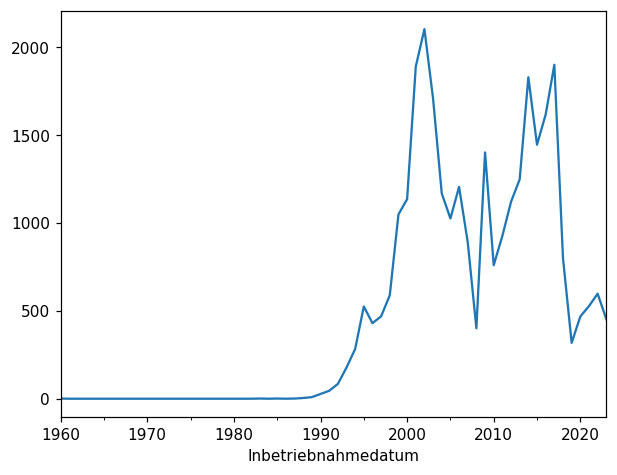

In [223]:
df.resample('A', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot()

In [226]:
df['NameWindpark'].value_counts()

NameWindpark
Bürgerwindpark Reußenköge GmbH ＆ Co. KG    87
Windpark Midlum                            70
Windrad                                    54
Drohndorf                                  53
Dahme                                      51
                                           ..
Eschenloh Wind                              1
WP Breitenbach GE27164792                   1
Willenhofen                                 1
Haiwind 2                                   1
WKA Schulzendorf                            1
Name: count, Length: 10694, dtype: int64

### Missing data
- Note: Inbetriebnahmedatum missing values because these turbines have status EinheitBetriebsstatus = In Planung
    - That means we have full data for Inbetriebnahmedatum since we filter out turbines in planning!

In [179]:
df.isna().sum()

Land                                      0
Bundesland                                0
Landkreis                                 0
Postleitzahl                              0
Ort                                       0
Laengengrad                             895
Breitengrad                             895
Registrierungsdatum                       0
Inbetriebnahmedatum                    2241
EinheitBetriebsstatus                     0
Energietraeger                            0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung     9509
Einspeisungsart                         652
NameWindpark                            807
Lage                                      0
Hersteller                              330
Technologie                               0
Typenbezeichnung                        346
Nabenhoehe                              761
Rotordurchmesser                        386
Rotorblattenteisungssystem      

In [157]:
df.head(2)

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,GeplantesInbetriebnahmedatum,Seelage,ClusterNordsee,Wassertiefe,Kuestenentfernung,ClusterOstsee
0,Deutschland,Hessen,Werra-Meißner-Kreis,34298.0,Helsa,9.739374,51.270068,2019-02-13,2017-09-01,In Betrieb,Wind,3000.0,3000.0,1.0,Volleinspeisung,Windpark Kreuzstein,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E-115,149.08,115.71,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Deutschland,Schleswig-Holstein,Segeberg,23824.0,Damsdorf,10.299400,54.073831,2019-02-01,2017-09-28,In Betrieb,Wind,3000.0,3000.0,0.0,Volleinspeisung,Damsdorf,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E-115,135.40,115.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dates

#### Date range of Registrierungsdatum is Jan 2019 to May 2023

In [159]:
# df.sort_values(by='Registrierungsdatum', ascending=True)

In [160]:
print(df['Registrierungsdatum'].min())
print(df['Registrierungsdatum'].max())

2019-01-31 00:00:00
2023-05-26 00:00:00


In [161]:
# Resample on datetime
# Alternative using groupby: df.groupby(pd.Grouper(freq='W', key='Registrierungsdatum'))['Registrierungsdatum'].count()
df.resample('A', on='Registrierungsdatum')['Registrierungsdatum'].count()

Registrierungsdatum
2019-12-31    13176
2020-12-31    14736
2021-12-31     3986
2022-12-31     1633
2023-12-31      953
Freq: A-DEC, Name: Registrierungsdatum, dtype: int64

In [133]:
# df.resample('A', on='Registrierungsdatum')['Registrierungsdatum'].count().plot.bar()

#### Date range of Inbetriebnahmedatum is 1960 to 2023
- Process for registering 

In [163]:
print(df['Inbetriebnahmedatum'].min())
print(df['Inbetriebnahmedatum'].max())

1960-04-02 00:00:00
2023-05-26 00:00:00


<Axes: title={'center': 'Test'}, xlabel='Inbetriebnahmedatum'>

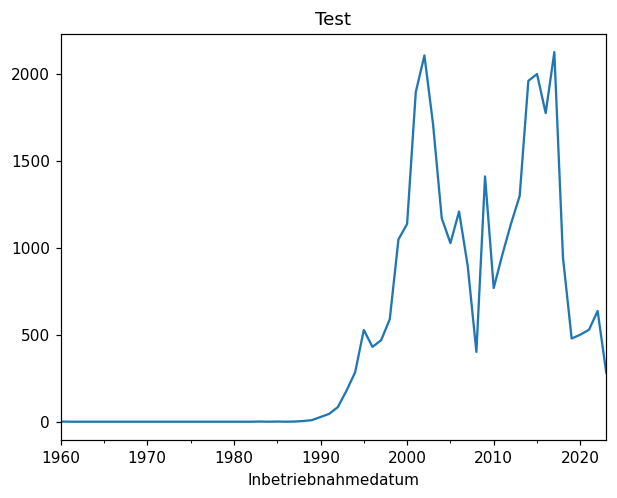

In [164]:
df.resample('A', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot(title='Test')

<Axes: title={'center': 'Test'}, xlabel='Inbetriebnahmedatum'>

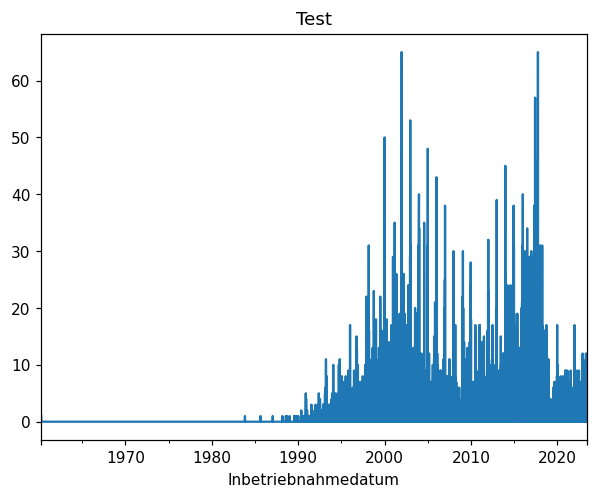

In [165]:
df.resample('D', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot(title='Test')

### Unique value counts

In [20]:
df['Technologie'].value_counts()

Technologie
Horizontalläufer    34027
Vertikalläufer        457
Name: count, dtype: int64

In [21]:
df['EinheitBetriebsstatus'].value_counts()

EinheitBetriebsstatus
In Betrieb                   30983
In Planung                    2464
Endgültig stillgelegt          999
Vorübergehend stillgelegt       38
Name: count, dtype: int64

In [40]:
# Land vs offshore
df['Lage'].value_counts()

Lage
Windkraft an Land    32700
Windkraft auf See     1784
Name: count, dtype: int64

In [41]:
df['AnschlussAnHoechstOderHochSpannung'].value_counts()

AnschlussAnHoechstOderHochSpannung
0.0    15554
1.0     9077
Name: count, dtype: int64

In [43]:
df['Hersteller'].value_counts()

Hersteller
ENERCON GmbH                        13057
Vestas Deutschland GmbH              6600
Nordex Energy GmbH                   2228
Siemens Wind Power GmbH & Co. KG     1531
Senvion Deutschland GmbH             1495
                                    ...  
Svit Vitru                              1
ESPV-TEC GmbH & Co. KG                  1
SMA Solar Technology AG                 1
WES IBS GmbH                            1
SB Energy UK Ltd.                       1
Name: count, Length: 115, dtype: int64

### Summary statistics of numerical continuous features
- Looks like I'll want wind speed data for height 100m

In [50]:
df[['Bruttoleistung', 'Nettonennleistung', 'Nabenhoehe', 'Rotordurchmesser']].describe()

,Bruttoleistung,Nettonennleistung,Nabenhoehe,Rotordurchmesser
count,34484.000000,34484.000000,33631.000000,34031.000000
mean,2370.309200,2370.309200,98.725831,87.096264
std,1681.910702,1681.910702,34.785787,35.863944
min,0.120000,0.120000,0.360000,0.300000
25%,1500.000000,1500.000000,70.000000,66.000000
50%,2000.000000,2000.000000,98.000000,82.000000
75%,3050.000000,3050.000000,134.000000,115.000000
max,20000.000000,20000.000000,200.000000,200.000000


### Create a date range/index and group turbine records on date they went into operation
- Also aggregate some of the other columns on grouped days as well (e.g. average blade diameter, etc)

In [173]:
df[df['Laengengrad'].isna() & (df['EinheitBetriebsstatus'] != 'In Betrieb')]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,GeplantesInbetriebnahmedatum,Seelage,ClusterNordsee,Wassertiefe,Kuestenentfernung,ClusterOstsee
97,Deutschland,Schleswig-Holstein,Nordfriesland,25873.0,Rantrum,NaN,NaN,2019-02-04,2018-04-24,Endgültig stillgelegt,Wind,10.0,10.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),PSW,Windkraft an Land,PSW-Energiesysteme GmbH,Horizontalläufer,EN-Drive 2000.3 M,10.0,7.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2194,Deutschland,Niedersachsen,Uelzen,29584.0,Himbergen,NaN,NaN,2019-03-03,2019-02-20,Endgültig stillgelegt,Wind,10.0,10.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Kleinwindkraftanlage,Windkraft an Land,PSW-Energiesysteme GmbH,Vertikalläufer,EN-Drive 2000.3 - 10 kW,NaN,7.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,Deutschland,Bayern,Oberallgäu,87499.0,Wildpoldsried,NaN,NaN,2019-03-10,NaT,In Planung,Wind,1.4,1.4,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Wind of Change,Windkraft an Land,Sonstige,Horizontalläufer,Wind of Change 1400,12.1,1.40,NaN,2022-06-03,NaN,NaN,NaN,NaN,NaN
4464,Deutschland,Schleswig-Holstein,Schleswig-Flensburg,24989.0,Dollerup,NaN,NaN,2019-04-30,2019-04-16,Endgültig stillgelegt,Wind,7.5,7.5,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,Weinack Windenergie Anlagen GmbH,Horizontalläufer,WWA Falcon 40,18.0,7.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4715,Deutschland,Nordrhein-Westfalen,Minden-Lübbecke,32609.0,Hüllhorst,NaN,NaN,2019-05-05,2015-07-12,Endgültig stillgelegt,Wind,1.2,1.2,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Windrad,Windkraft an Land,K.D.-Stahl- und Maschinenbau GmbH,Vertikalläufer,Amperius,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34333,Deutschland,Schleswig-Holstein,Dithmarschen,25764.0,Wesselburenerkoog,NaN,NaN,2023-05-01,NaT,In Planung,Wind,6.0,6.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),vertikal,Windkraft an Land,Sonstige,Horizontalläufer,Bayoung-FH3.6M-NEW,9.0,3.00,0.0,2023-09-01,NaN,NaN,NaN,NaN,NaN
34334,Deutschland,Schleswig-Holstein,Nordfriesland,25882.0,Tetenbüll,NaN,NaN,2023-05-03,NaT,In Planung,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,SkyWind GmbH,Horizontalläufer,SkyWind NG,8.0,1.50,0.0,2023-05-22,NaN,NaN,NaN,NaN,NaN
34336,Deutschland,Niedersachsen,Uelzen,29571.0,Rosche,NaN,NaN,2023-05-06,NaT,In Planung,Wind,0.6,0.6,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Sky Wind Dachanlage,Windkraft an Land,SkyWind GmbH,Horizontalläufer,Sky Wind NG,9.0,1.35,0.0,2023-06-10,NaN,NaN,NaN,NaN,NaN
34340,Deutschland,Nordrhein-Westfalen,Dortmund,44269.0,Dortmund,NaN,NaN,2023-05-08,NaT,In Planung,Wind,2.0,2.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Conciso - Windpark,Windkraft an Land,SkyWind GmbH,Horizontalläufer,SkyWind NG 1kW,163.0,1.00,0.0,2023-06-30,NaN,NaN,NaN,NaN,NaN
